# Introduction
This Jupyter Notebook provides a comprehensive guide to building a text classification model for detecting toxic comments. The model uses the Civil Comments dataset and the RoBERTa model from the Hugging Face transformers library. The process includes data preparation, model training with a custom weighted loss function to handle class imbalance, and a detailed evaluation of the model's performance.

In [ ]:
# ============================================
# Toxic vs Non-Toxic Text Classification (Civil Comments + RoBERTa)
# ============================================

!pip installs (uncomment if running in a fresh environment)
!pip install --upgrade datasets
!pip install transformers scikit-learn pandas matplotlib torch --quiet

In [ ]:
import os
import numpy as np
import pandas as pd
import torch
from dataclasses import dataclass
from typing import Dict, Any

from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer,
)

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    roc_auc_score,
    confusion_matrix,
    classification_report,
)
import matplotlib.pyplot as plt

# ---------------------------
# 0) Config & Reproducibility
# ---------------------------
SEED = 42
MODEL_NAME = "roberta-base"
OUTPUT_DIR = "./roberta_toxic_cc"
os.makedirs(OUTPUT_DIR, exist_ok=True)

def seed_everything(seed: int = 42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
seed_everything(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [ ]:
# ------------------------------------------------
# 1) Load Civil Comments & Binarize 'toxicity' -> label
# ------------------------------------------------
raw = load_dataset("civil_comments")   # splits: train, test
THRESH = 0.5

def to_binary(example):
    return {"label": int(example["toxicity"] >= THRESH)}

raw = raw.map(to_binary)

# Keep only what we need
raw = raw.remove_columns([c for c in raw["train"].column_names if c not in ["text", "label"]])


Map:   0%|          | 0/97320 [00:00<?, ? examples/s]

Map:   0%|          | 0/97320 [00:00<?, ? examples/s]

In [ ]:
# ------------------------------------------------
# 2) Manual stratified split (train -> train/valid)
# ------------------------------------------------
y_all = np.array(raw["train"]["label"])
idx_all = np.arange(len(y_all))
train_idx, valid_idx = train_test_split(
    idx_all, test_size=0.1, random_state=SEED, stratify=y_all
)

train_ds = raw["train"].select(train_idx.tolist())
valid_ds = raw["train"].select(valid_idx.tolist())
test_ds  = raw["test"]  # provided split

print(f"Train size: {len(train_ds)} | Valid size: {len(valid_ds)} | Test size: {len(test_ds)}")


Train size: 1624386 | Valid size: 180488 | Test size: 97320


In [ ]:
# ===== Set your target sizes here =====
TARGET_TRAIN = 100_000   # e.g., 100k instead of 1.6M
TARGET_VALID = 10_000    # e.g., 10k instead of 180k
TARGET_TEST  = 10_000    # e.g., 10k instead of 97k

def stratified_downsample(ds, n_total, seed=SEED):
    """Return a stratified subset with n_total rows."""
    y = np.array(ds["label"])
    idx = np.arange(len(y))
    if n_total >= len(y):
        return ds  # nothing to do
    sel_idx, _ = train_test_split(idx, train_size=n_total, random_state=seed, stratify=y)
    return ds.select(sel_idx.tolist())

# Apply downsizing
train_ds = stratified_downsample(train_ds, TARGET_TRAIN)
valid_ds = stratified_downsample(valid_ds, TARGET_VALID)
test_ds  = stratified_downsample(test_ds,  TARGET_TEST)

print(f"[SMALL] Train size: {len(train_ds)} | Valid size: {len(valid_ds)} | Test size: {len(test_ds)}")

# IMPORTANT: Recompute class weights on the downsized TRAIN set
y_train = np.array(train_ds["label"])
pos = (y_train == 1).sum()
neg = (y_train == 0).sum()
class_weights = torch.tensor(
    [len(y_train) / (2 * neg), len(y_train) / (2 * pos)],
    dtype=torch.float
)
print("Class weights (small set):", class_weights.tolist())

[SMALL] Train size: 100000 | Valid size: 10000 | Test size: 10000
Class weights (small set): [0.5434605479240417, 6.252344608306885]


In [ ]:
# ---------------------------
# 3) Tokenizer & Encoding
# ---------------------------
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def encode(batch):
    return tokenizer(batch["text"], truncation=True)

enc_train = train_ds.map(encode, batched=True, remove_columns=["text"])
enc_valid = valid_ds.map(encode, batched=True, remove_columns=["text"])
enc_test  = test_ds.map(encode,  batched=True, remove_columns=["text"])

collator = DataCollatorWithPadding(tokenizer=tokenizer)

Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [ ]:
# ---------------------------
# 4) Class Weights (Imbalance)
# ---------------------------
y_train = np.array(train_ds["label"])
pos = (y_train == 1).sum()
neg = (y_train == 0).sum()
class_weights = torch.tensor(
    [len(y_train) / (2 * neg), len(y_train) / (2 * pos)],
    dtype=torch.float
)
print("Class weights:", class_weights.tolist())

Class weights: [0.5434605479240417, 6.252344608306885]


In [ ]:
# ---------------------------
# 5) Model
# ---------------------------
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# ---------------------------
# 6) Custom Trainer with Weighted Loss (fixed signature)
# ---------------------------
class WeightedTrainer(Trainer):
    def __init__(self, *args, class_weights: torch.Tensor = None, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    # accept num_items_in_batch to be compatible with recent HF versions
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        weight = self.class_weights.to(logits.device) if self.class_weights is not None else None
        loss_fct = torch.nn.CrossEntropyLoss(weight=weight)
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

In [ ]:
# ---------------------------
# 7) Metrics
# ---------------------------
def compute_metrics(eval_pred) -> Dict[str, Any]:
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    acc = accuracy_score(labels, preds)
    prec, rec, f1, _ = precision_recall_fscore_support(labels, preds, average="binary", zero_division=0)
    # ROC-AUC on positive class
    probs_pos = torch.softmax(torch.tensor(logits), dim=1)[:, 1].numpy()
    try:
        auc = roc_auc_score(labels, probs_pos)
    except Exception:
        auc = float("nan")
    return {"accuracy": acc, "precision": prec, "recall": rec, "f1": f1, "roc_auc": auc}

In [ ]:
# ---------------------------
# 8) Training Arguments
# ---------------------------
args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    report_to="none",
    seed=SEED,
    fp16=torch.cuda.is_available(),   # mixed precision if GPU
)

In [ ]:
# ---------------------------
# 9) Train
# ---------------------------
trainer = WeightedTrainer(
    model=model,
    args=args,
    train_dataset=enc_train,
    eval_dataset=enc_valid,
    data_collator=collator,
    compute_metrics=compute_metrics,
    class_weights=class_weights,
)

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Roc Auc
1,0.472500,0.371220,0.945400,0.654878,0.671250,0.662963,0.957404
2,0.399900,0.528119,0.950500,0.692794,0.685000,0.688875,0.951861
3,0.303100,0.539135,0.945100,0.637761,0.726250,0.679135,0.958020


TrainOutput(global_step=18750, training_loss=0.4166584000651042, metrics={'train_runtime': 970.3231, 'train_samples_per_second': 309.175, 'train_steps_per_second': 19.323, 'total_flos': 3.120980583133824e+16, 'train_loss': 0.4166584000651042, 'epoch': 3.0})


Test metrics: {'eval_loss': 0.5380666255950928, 'eval_accuracy': 0.9488, 'eval_precision': 0.6782608695652174, 'eval_recall': 0.6833541927409261, 'eval_f1': 0.6807980049875312, 'eval_roc_auc': 0.9587553673697382, 'eval_runtime': 10.4958, 'eval_samples_per_second': 952.765, 'eval_steps_per_second': 59.548, 'epoch': 3.0}

Test Set Summary:
    accuracy  precision    recall        f1   roc_auc
0    0.9488   0.678261  0.683354  0.680798  0.958755

Classification Report:
              precision    recall  f1-score   support

   Non-toxic       0.97      0.97      0.97      9201
       Toxic       0.68      0.68      0.68       799

    accuracy                           0.95     10000
   macro avg       0.83      0.83      0.83     10000
weighted avg       0.95      0.95      0.95     10000



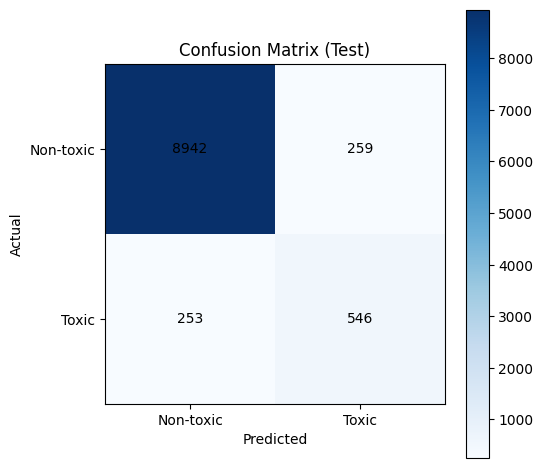

In [ ]:
# ---------------------------
# 10) Evaluate on Test
# ---------------------------
eval_test = trainer.evaluate(enc_test)
print("\nTest metrics:", eval_test)

pred = trainer.predict(enc_test)
y_true = pred.label_ids
y_prob = torch.softmax(torch.tensor(pred.predictions), dim=1).numpy()
y_pred = y_prob.argmax(axis=1)

# Compact test summary
summary = pd.DataFrame([{
    "accuracy": accuracy_score(y_true, y_pred),
    "precision": precision_recall_fscore_support(y_true, y_pred, average="binary", zero_division=0)[0],
    "recall":    precision_recall_fscore_support(y_true, y_pred, average="binary", zero_division=0)[1],
    "f1":        precision_recall_fscore_support(y_true, y_pred, average="binary", zero_division=0)[2],
    "roc_auc":   roc_auc_score(y_true, y_prob[:, 1]) if len(np.unique(y_true)) > 1 else np.nan
}])
print("\nTest Set Summary:\n", summary)

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=["Non-toxic", "Toxic"]))

# Confusion matrix plot
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5.5, 5))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix (Test)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
for (i, j), v in np.ndenumerate(cm):
    plt.text(j, i, str(v), ha="center", va="center")
plt.xticks([0, 1], ["Non-toxic", "Toxic"])
plt.yticks([0, 1], ["Non-toxic", "Toxic"])
plt.colorbar()
plt.tight_layout()
plt.show()


In [ ]:

# ---------------------------
# 11) Save & Simple Inference
# ---------------------------
trainer.save_model(OUTPUT_DIR)
tokenizer.save_pretrained(OUTPUT_DIR)
model.to(device).eval()

def predict_toxicity(text: str) -> str:
    batch = tokenizer(text, return_tensors="pt", truncation=True).to(device)
    with torch.no_grad():
        logits = model(**batch).logits
    label = int(torch.argmax(logits, dim=1).item())
    return "Toxic" if label == 1 else "Non-toxic"



In [ ]:
# Quick demo
user_text = input("Enter a comment: ")
print("Prediction:", predict_toxicity(user_text))

Enter a comment: You are welcome
Prediction: Non-toxic


# Conclusion

This notebook provides a complete and reproducible workflow for fine-tuning a pre-trained RoBERTa model for toxic comment classification. The use of a custom Trainer class with weighted loss is a key technique for addressing the highly imbalanced nature of the dataset. The comprehensive evaluation section, including the classification report and confusion matrix, gives a clear picture of the model's performance beyond simple accuracy. This process can be easily adapted for other text classification tasks with similar data characteristics.